## Fastext своими руками

Fastext использует те же самые алгоритмы, что и word2vec. Единственное (но очень значимое) отличие в том, что в fastext используются не только слова, но и символьные нграммы. Это частично помогает решить проблему с несловарными словами. Если в словаре word2vec модели нет нужного слова, то никакого вектора для него создать не получится. В fastext же, если слова нет в словаре целиком, то можно проверить по словарю символьные нграммы этого слова и составить итоговый вектор из них. Большинство несловарных слов сильно пересекаются со словарными (основами, аффиксами) и за счет этого найденный вектор получается достаточно хороший. 
Реализовать простую версию fastext немного сложнее, поэтому я вынес его в отдельный ноутбук.

In [4]:
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("Torch version:", torch.__version__)

Using device: cuda
Torch version: 2.2.1


Возьмем тот же небольшой кусок википедии

In [2]:
# в нашем корпусе 20к текстов
wiki = open('wiki_data.txt').read().split('\n')

In [33]:
wiki[0]

'######Новостройка (Нижегородская область)############Новостро́йка — сельский посёлок в Дивеевском районе Нижегородской области. Входит в состав Сатисского сельсовета.############Посёлок расположен в 12,5 км к югу от села Дивеева и 1 км к западу от города Сарова, на правом берегу реки Вичкинза (правый приток реки Сатис). Окружён смешанными лесами. Соединён асфальтовой дорогой с посёлком Цыгановка (1,5 км) и грунтовыми просёлочными дорогами с посёлком Сатис (3,5 км). Название Новостройка является сугубо официальным, местное население использует исключительно альтернативное название — Хитрый. Употребляется языковой оборот «…на Хитром». Ранее используемые названия — Песчаный, Известковый.############Основан в 1920-х годах переселенцами из соседних сёл Аламасово и Нарышкино (расположенных соответственно в 8 и 14 км к западу в Вознесенском районе).############Традиционно в посёлке жили рабочие совхоза «Вперёд» (центр в посёлке Сатис). Возле посёлка расположен карьер где активно добывали дол

In [34]:
len(wiki)

20003

Базовая токенизация остается точно такой же

In [5]:
import re
from collections import Counter
def tokenize(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens


Второй базовый элемент - это нграммер, чтобы разбивать токен на символьные нграммы
Обратите внимание что к токену добавляются <> чтобы учесть в нграммах, что они стоят в начале или в конце

In [6]:
def ngrammer(raw_string, n=2):
    ngrams = []
    raw_string = ''.join(['<', raw_string, '>'])
    for i in range(0,len(raw_string)-n+1):
        ngram = ''.join(raw_string[i:i+n])
        if ngram == '<' or ngram == '>': # сами по себе <> как токены не нужны
            continue
        ngrams.append(ngram)
    return ngrams

Следующая функция проходится по токенам и разбивает каждый токен на подсимвольные нграммы в заданном интервале

In [7]:
def split_tokens(tokens, min_ngram_size, max_ngram_size):
    tokens_with_subwords = []
    for token in tokens:
        subtokens = []
        for i in range(min_ngram_size, max_ngram_size+1):
            if len(token) > i:
                subtokens.extend(ngrammer(token, i))
        tokens_with_subwords.append(subtokens)
    return tokens_with_subwords


In [8]:
split_tokens(['подсимвольные', 'нграммы'], 3, 4)

[['<по',
  'под',
  'одс',
  'дси',
  'сим',
  'имв',
  'мво',
  'вол',
  'оль',
  'льн',
  'ьны',
  'ные',
  'ые>',
  '<под',
  'подс',
  'одси',
  'дсим',
  'симв',
  'имво',
  'мвол',
  'воль',
  'ольн',
  'льны',
  'ьные',
  'ные>'],
 ['<нг',
  'нгр',
  'гра',
  'рам',
  'амм',
  'ммы',
  'мы>',
  '<нгр',
  'нгра',
  'грам',
  'рамм',
  'аммы',
  'ммы>']]

Теперь нам нужно спаппить токены и подсимвольные нграммы в индексы и для этого нужно построить словарь. Это немного сложнее чем раньше потому что мы хотим иметь в словаре и полные слова и символьные нграммы, но нам нужно иметь отдельный список только полных слов, чтобы потом иметь возможность находить ближайшие слова.

Чтобы было удобнее со всеми переменными напишем класс для токенизации

In [9]:
class SubwordTokenizer:
    def __init__(self, ngram_range=(1,1), min_count=5):
        self.min_ngram_size, self.max_ngram_size = ngram_range
        self.min_count = min_count
        self.subword_vocab = None
        self.fullword_vocab = None
        self.vocab = None
        self.id2word = None
        self.word2id = None

    def build_vocab(self, texts):
        # чтобы построить словарь нужно пройти по всему корпусу и собрать частоты всех уникальных слов и нграммов
        unfiltered_subword_vocab = Counter()
        unfiltered_fullword_vocab = Counter()
        for text in texts:
            tokens = tokenize(text)
            unfiltered_fullword_vocab.update(tokens)
            subwords_per_token = split_tokens(tokens, self.min_ngram_size, self.max_ngram_size)
            for subwords in subwords_per_token:
                # в одном слове могут быть одинаковые нграммы поэтому возьмем только уникальные
                unfiltered_subword_vocab.update(set(subwords))

        self.fullword_vocab = set()
        self.subword_vocab = set()

        # теперь отфильтруем по частоте
        for word, count in unfiltered_fullword_vocab.items():
            if count >= self.min_count:
                self.fullword_vocab.add(word)
        # для нграммов сделаем порог побольше чтобы не создавать слишком много нграммов
        # и учитывать только действительно частотные
        for word, count in unfiltered_subword_vocab.items():
            if count >= (self.min_count * 100):
                self.subword_vocab.add(word)

        # общий словарь
        self.vocab = self.fullword_vocab | self.subword_vocab
        self.id2word = {i:word for i,word in enumerate(self.vocab)}
        self.word2id = {word:i for i,word in self.id2word.items()}

    def subword_tokenize(self, text):
        if self.vocab is None:
            raise AttributeError('Vocabulary is not built!')
        # разбиваем на токены
        tokens = tokenize(text) 
        # каждый токен разбиваем на символьные нграммы
        tokens_with_subwords = split_tokens(tokens, self.min_ngram_size, self.max_ngram_size)
        # оставляет только токены и нграммы которые есть в словаре
        only_vocab_tokens_with_subwords = []
        for full_token, sub_tokens in zip(tokens, tokens_with_subwords):
            filtered = []
            if full_token in self.vocab:
                # само слово и нграммы хранятся в одном списке 
                # но слово будет всегда первым в списке
                filtered.append(full_token)
            filtered.extend([subtoken for subtoken in set(sub_tokens) if subtoken in self.vocab])
            only_vocab_tokens_with_subwords.append(filtered)

        return only_vocab_tokens_with_subwords

    def encode(self, subword_tokenized_text):
        # маппим токены и нграммы в их индексы в словаре
        encoded_text = []
        for token in subword_tokenized_text:
            if not token:
                continue
            encoded_text.append([self.word2id[token[0]]] + [self.word2id[t] for t in set(token[1:]) if t in self.word2id and t != token[0]])
        return encoded_text

    def __call__(self, text):
        return self.encode(self.subword_tokenize(text))


In [10]:
tokenizer = SubwordTokenizer(ngram_range=(2,4), min_count=10)

In [11]:
tokenizer.build_vocab(wiki)

In [12]:
tokenizer.subword_tokenize('Текст для тестирования токенизации')

[['текст',
  'кс',
  'текс',
  'екст',
  '<тек',
  'екс',
  'те',
  'ст',
  '<т',
  '<те',
  'ст>',
  'тек',
  'ек',
  'кст',
  'т>'],
 ['для', 'я>', '<д', 'ля', 'дл'],
 ['тестирования',
  'сти',
  'рова',
  'тес',
  'ния>',
  'ни',
  'ан',
  'ия',
  'ов',
  'ва',
  'тест',
  'те',
  '<т',
  'ес',
  'иров',
  'иро',
  'ести',
  'ия>',
  'ти',
  'ания',
  'ани',
  'ест',
  'ро',
  'я>',
  'вани',
  'ован',
  'ст',
  'ир',
  '<те',
  'ова',
  'тиро',
  'ния',
  'ван',
  'тир',
  'ров'],
 ['аци',
  'из',
  'ции',
  'ни',
  'ток',
  'ац',
  '<т',
  'ок',
  'токе',
  'ци',
  'то',
  'низа',
  'ен',
  'ции>',
  'изац',
  'ени',
  'кен',
  'ке',
  'и>',
  '<то',
  'ии',
  'заци',
  'ации',
  'за',
  'оке',
  'ии>',
  'низ',
  'иза',
  'зац']]

In [13]:
len(tokenizer.vocab)

54860

In [14]:
tokenizer('Текст для тестирования токенизации')

[[17128,
  48867,
  22069,
  14306,
  31852,
  52211,
  54630,
  51440,
  23237,
  23482,
  46611,
  41211,
  34226,
  37626,
  29951],
 [34247, 38295, 45161, 30652, 3194],
 [52079,
  52626,
  19271,
  54403,
  20817,
  34291,
  40248,
  39411,
  44667,
  26643,
  43119,
  54630,
  23237,
  33485,
  31413,
  30470,
  10449,
  48206,
  34836,
  9415,
  51384,
  24627,
  3473,
  38295,
  34365,
  1298,
  51440,
  45178,
  23482,
  52085,
  54339,
  41874,
  11104,
  12961,
  11706],
 [8457,
  24697,
  19518,
  34291,
  13989,
  21056,
  23237,
  15508,
  26030,
  38931,
  52437,
  29476,
  42971,
  46786,
  53072,
  30942,
  35429,
  44448,
  26978,
  1925,
  43304,
  4937,
  7313,
  15817,
  21201,
  4838,
  16186,
  20366,
  52190]]

Реализуем функцию которая будет генерировать батчи для обучения. Сделаем только скипграмм алгоритм. То есть нам нужны пары токен_1 - токен_2 встретившиеся в одном контексте, только для токена_1 мы еще будет учитывать его символьный нграммы, а токен_2 будет предсказывать только целиком без разбиение на поднграммы

In [15]:
import numpy as np

def pad_sequences(sequences, maxlen, padding='post', value=0):
    """
    sequences: list of lists (разной длины)
    возвращает np.array shape (len(sequences), maxlen)
    """
    res = np.full((len(sequences), maxlen), value, dtype='int64')
    for i, seq in enumerate(sequences):
        if not seq:
            continue
        if len(seq) >= maxlen:
            if padding == 'post':
                res[i] = np.array(seq[:maxlen])
            else:
                res[i] = np.array(seq[-maxlen:])
        else:
            if padding == 'post':
                res[i, :len(seq)] = np.array(seq)
            else:
                res[i, -len(seq):] = np.array(seq)
    return res


In [35]:
# пример паддинга
# seq = [[1,2,3], [1,2], [1,2,3,4,5]]
# pad_sequences(seq, 5, value=0)

In [16]:
def gen_batches_ft(sentences, tokenizer, window=5, batch_size=1000, maxlen=20):
    """
    Skip-gram FastText:
    X — список [word_id, subword_id, subword_id, ...] (потом паддим до maxlen),
    y — индекс контекстного полного слова.
    """
    left_context_length = (window/2).__ceil__()
    right_context_length = window // 2
    
    while True:
        X = []
        y = []

        for sent in sentences:
            sent_encoded = tokenizer(sent)  # список [ [full, sub1, sub2...], ... ]
            for i in range(len(sent_encoded)-1):
                word_with_subtokens = sent_encoded[i]
                context = sent_encoded[max(0, i-left_context_length):i] + sent_encoded[i+1:i+right_context_length]
                for context_word_with_subtokens in context:
                    only_full_word_context_token = context_word_with_subtokens[0]
                    X.append(word_with_subtokens)
                    y.append(only_full_word_context_token)
                    
                    if len(X) >= batch_size:
                        X_arr = pad_sequences(X, maxlen=maxlen, padding='post', value=0)
                        y_arr = np.array(y, dtype='int64')
                        yield (X_arr, y_arr)
                        X = []
                        y = []


In [17]:
gen = gen_batches_ft(wiki, tokenizer, batch_size=5)

In [18]:
next(gen)

(array([[19785, 14445,  4734, 38981, 39411, 21632,  4806, 40017, 44737,
         41377, 14864,  3473, 29363, 51440, 13843, 13322, 27033, 33981,
         10936, 21027],
        [18640, 15052, 45642, 38981, 34291, 16938,  9183,  2582, 25851,
         33639, 16040, 54787, 13763, 21383, 54458, 44265, 15125, 26248,
         52929, 29244],
        [18640, 15052, 45642, 38981, 34291, 16938,  9183,  2582, 25851,
         33639, 16040, 54787, 13763, 21383, 54458, 44265, 15125, 26248,
         52929, 29244],
        [17202, 10123,   529, 40604, 22361, 28421, 21158,  7215, 49441,
         41229, 47254, 51440,  2293,  4067,   287, 24305, 38593, 37430,
         37589, 16697],
        [17202, 10123,   529, 40604, 22361, 28421, 21158,  7215, 49441,
         41229, 47254, 51440,  2293,  4067,   287, 24305, 38593, 37430,
         37589, 16697]]),
 array([18640, 19785, 17202, 19785, 18640]))

Код для обучения очень простой. Мы просто сопостовляет каждому токену и нграмму эмбединг и усредняем все эмбединги внутри слова, чтобы получить итоговый. По нему мы пытаемся предсказать целевое слово.

In [19]:
class FastTextSkipGram(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.fc = nn.Linear(emb_dim, vocab_size)

    def forward(self, x):
        """
        x: LongTensor (batch, maxlen)
        """
        e = self.emb(x)          # (batch, maxlen, emb_dim)
        mean = e.mean(dim=1)     # (batch, emb_dim)  как Lambda(lambda x: x.mean(axis=1))
        logits = self.fc(mean)   # (batch, vocab_size)
        return logits


In [21]:
vocab_size = len(tokenizer.vocab)
emb_dim = 100

model = FastTextSkipGram(vocab_size, emb_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [22]:
train_gen = gen_batches_ft(wiki[:19000], tokenizer, window=10, batch_size=100, maxlen=20)
valid_gen = gen_batches_ft(wiki[19000:], tokenizer, window=10, batch_size=100, maxlen=20)

steps_per_epoch = 10000
validation_steps = 100
num_epochs = 10

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # --- TRAIN ---
    model.train()
    epoch_loss = 0.0
    for step in range(steps_per_epoch):
        X_batch, y_batch = next(train_gen)
        X_batch = torch.LongTensor(X_batch).to(device)
        y_batch = torch.LongTensor(y_batch).to(device)

        optimizer.zero_grad()
        logits = model(X_batch)               # (batch, vocab_size)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    epoch_loss /= steps_per_epoch
    train_losses.append(epoch_loss)

    # --- VAL ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for _ in range(validation_steps):
            X_batch, y_batch = next(valid_gen)
            X_batch = torch.LongTensor(X_batch).to(device)
            y_batch = torch.LongTensor(y_batch).to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            val_loss += loss.item()
    val_loss /= validation_steps
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"train loss: {epoch_loss:.4f}, val loss: {val_loss:.4f}")


Epoch 1/10 - train loss: 9.6563, val loss: 9.3935
Epoch 2/10 - train loss: 9.0190, val loss: 9.2979
Epoch 3/10 - train loss: 8.9138, val loss: 8.7710
Epoch 4/10 - train loss: 8.9191, val loss: 9.2170
Epoch 5/10 - train loss: 8.8527, val loss: 8.7508
Epoch 6/10 - train loss: 8.7838, val loss: 8.6537
Epoch 7/10 - train loss: 8.8624, val loss: 8.9611
Epoch 8/10 - train loss: 8.8840, val loss: 8.7881
Epoch 9/10 - train loss: 8.7953, val loss: 8.5995
Epoch 10/10 - train loss: 8.8265, val loss: 9.1674


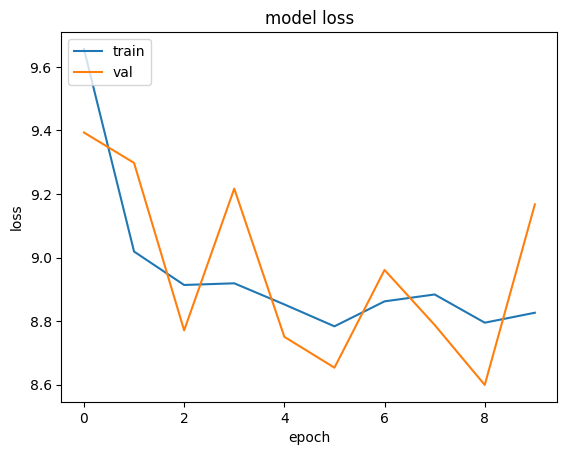

In [23]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

Искать похожие немного сложнее так как нам нужно для всех полных слов еще и учесть информацию об их поднграммах.

In [25]:
embeddings = model.emb.weight.detach().cpu().numpy()   # (vocab_size, emb_dim)


In [26]:
full_word_embeddings = np.zeros((len(tokenizer.fullword_vocab), 100)) # матрица с эмбедингами полных слов + нграммы
id2word = list(tokenizer.fullword_vocab)

for i, word in enumerate(tokenizer.fullword_vocab):
    subwords = tokenizer(word)[0]
    full_word_embeddings[i] = embeddings[[i for i in subwords]].mean(axis=0) 

In [27]:
def most_similar_ft(word, embeddings, tokenizer):
    subwords = tokenizer(word)[0]
    word_embedding = embeddings[[i for i in subwords]].sum(axis=0)
    # idxs = [tokenizer.word2id[i] for i in tokenizer.fullword_vocab]
    similar = [id2word[i] for i in 
               cosine_distances(word_embedding.reshape(1, -1), full_word_embeddings).argsort()[0][:20]]
    return similar

Из результатов поиска видно что fastext учитывает поднграмы и находит как ближайшие не только близкие по смыслу но и по форме

In [28]:
most_similar_ft('семья', embeddings, tokenizer)

['семья',
 'семьях',
 'семь',
 'семьям',
 'семью',
 'семьей',
 'семьёй',
 'семьи',
 'семье',
 '«семь',
 'восемь',
 'семьями',
 'семьи»',
 'семя',
 'семей',
 'семена',
 'семейств',
 'семейства',
 'семеноводства',
 'семейная']

In [29]:
most_similar_ft("церковь", embeddings, tokenizer)

['церковь',
 '«церковь',
 'церковью',
 'церковному',
 'церковное',
 'церковном',
 'церковной',
 'церковный',
 'церковную',
 'церковного',
 'церковные',
 'церковным',
 'церковных',
 'церковная',
 'цеков',
 'совершал',
 'мисирков',
 'очерков',
 'церковно-приходская',
 'церквях']

In [30]:
most_similar_ft("делать", embeddings, tokenizer)

['делать',
 'сделать',
 'проделать',
 'переделать',
 'дела»',
 'дела',
 'делам',
 'делают',
 'делал',
 'ехать',
 'делах',
 'держать',
 'делали',
 'делаются',
 'делала',
 'делить',
 'вызвать',
 'делами',
 'мешать',
 'послать']